In [1]:
from sqlalchemy import create_engine
import os
from os import listdir
from os.path import isfile, join
from datetime import datetime
import pandas as pd
import numpy as np
import geopandas
from geobr import read_municipality

from settings import *

In [2]:
engine = create_engine(connection_uri)

In [3]:
sql = """
SELECT estabelecimento_municipio_codigo AS CodMun, COUNT(*) AS aplicadas
FROM public.vacinacao_limpa 
GROUP BY CodMun
;
"""

df_apl = pd.read_sql(sql, engine)

df_apl

codmun  aplicadas
0     521590       2043
1     291730       7819
2     411850      41139
3     315010       1758
4     320313       9468
...      ...        ...
5565  317065       1620
5566  280220       2023
5567  412625      36436
5568  315680       7653
5569  316805       1765

[5570 rows x 2 columns]

In [4]:
sql = """
SELECT estabelecimento_municipio_codigo AS codmun, MAX(data_importacao_rnds) AS ultima_data
FROM public.vacinacao_limpa
GROUP BY codmun
;
"""

df_atualizacao = pd.read_sql(sql, engine)

df_atualizacao

codmun ultima_data
0     521590  2021-06-21
1     291730  2021-06-24
2     411850  2021-06-25
3     315010  2021-06-25
4     320313  2021-06-25
...      ...         ...
5565  317065  2021-06-23
5566  280220  2021-06-23
5567  412625  2021-06-26
5568  315680  2021-06-25
5569  316805  2021-06-21

[5570 rows x 2 columns]

In [5]:
sql = """
SELECT estabelecimento_municipio_codigo AS CodMun, COUNT(*) AS importados
FROM public.vacinacao_limpa 
WHERE estabelecimento_municipio_codigo <> paciente_endereco_coibgemunicipio
GROUP BY CodMun
;
"""

df_imp = pd.read_sql(sql, engine)

df_imp

codmun  importados
0     521590         241
1     291730        1053
2     411850        4734
3     315010         236
4     320313        1242
...      ...         ...
5565  317065         217
5566  280220         432
5567  412625       10136
5568  315680         597
5569  316805         442

[5570 rows x 2 columns]

In [6]:
sql = """
SELECT paciente_endereco_coibgemunicipio AS CodMun, COUNT(*) AS exportados
FROM public.vacinacao_limpa 
WHERE estabelecimento_municipio_codigo <> paciente_endereco_coibgemunicipio
GROUP BY CodMun
;
"""

df_exp = pd.read_sql(sql, engine)

df_exp

codmun  exportados
0     521590         511
1     291730        1111
2     411850        5360
3     320313        1621
4     315010         223
...      ...         ...
5616  317065         193
5617  280220         318
5618  412625        5874
5619  315680         965
5620  316805         153

[5621 rows x 2 columns]

In [7]:
sql = """
SELECT * FROM public.populacao
WHERE "CodMun" IS NOT NULL
;
"""

df_pop = pd.read_sql(sql, engine).drop(['nivel', 'CodEst', 'Sexo'], axis=1)

df_pop

CodMun  De 0 a 4 anos  De 5 a 9 anos  De 10 a 14 anos  \
0      110001.0            798            781              785   
1      110037.0            557            503              472   
2      110040.0            916            870              824   
3      110034.0            504            487              478   
4      110002.0           4073           4013             4224   
...         ...            ...            ...              ...   
11135  522200.0            494            492              430   
11136  522205.0            342            344              323   
11137  522220.0            290            272              242   
11138  522230.0            224            225              178   
11139  530010.0         105681          97123           105816   

       De 15 a 19 anos  De 20 a 24 anos  De 25 a 29 anos  De 30 a 34 anos  \
0                  830              856              958              920   
1                  578              546              561              490   
2                  919              984              948              851   
3                  512              514              607              540   
4                 4911             4966             4891             4814   
...                ...              ...              ...              ...   
11135              496              538              563              553   
11136              348              366              375              439   
11137              290              328              325              350   
11138              183              217              238              231   
11139           121390           126646           124607           130181   

       De 35 a 39 anos  De 40 a 44 anos  De 45 a 49 anos  De 50 a 54 anos  \
0                  895              775              801              738   
1                  485              508              481              366   
2                  822              754              781              604   
3                  564              578              481              428   
4                 4551             4037             3560             3177   
...                ...              ...              ...              ...   
11135              544              553              502              483   
11136              406              379              340              296   
11137              499              309              198              153   
11138              195              235              239              216   
11139           132624           121379           100623            86940   

       De 55 a 59 anos  De 60 a 64 anos  De 65 a 69 anos  De 70 a 74 anos  \
0                  653              439              339              220   
1                  270              220              182              117   
2                  414              352              259              184   
3                  378              323              233              139   
4                 2425             1794             1386              879   
...                ...              ...              ...              ...   
11135              390              318              196              172   
11136              253              161              133               81   
11137              142              105               50               43   
11138              196              168              112               79   
11139            68925            51302            37900            25584   

       De 75 a 79 anos  De 80 anos ou mais  
0                  163                 146  
1                   86                  69  
2                  122                  89  
3                  106                 100  
4                  553                 522  
...                ...                 ...  
11135               98                 112  
11136               58                  60  
11137               27              

In [8]:
df_pop = df_pop.groupby(['CodMun']).sum().sum(axis=1).reset_index(name='populacao').rename(columns={'CodMun':'codmun'})

df_pop

codmun  populacao
0     110001.0      22728
1     110002.0     109523
2     110003.0       5188
3     110004.0      85893
4     110005.0      16204
...        ...        ...
5565  522200.0      13977
5566  522205.0       8873
5567  522220.0       6312
5568  522230.0       5882
5569  530010.0    3055149

[5570 rows x 2 columns]

In [9]:
ibge_data_dir = os.path.join(os.path.abspath(''), '../../datasets/ibge/')

df_nomes = pd.read_csv(ibge_data_dir + 'municipio_latlon.csv')

df_nomes = df_nomes[['codigo_ibge', 'nome', 'latitude', 'longitude']]

df_nomes.columns = ['codmun', 'Município', 'lat', 'lon']

df_nomes['codmun'] = df_nomes['codmun'].astype('int').astype('str').str[:6].astype('int')

df_nomes

codmun            Município       lat      lon
0     520005      Abadia de Goiás -16.75730 -49.4412
1     310010  Abadia dos Dourados -18.48310 -47.3916
2     520010            Abadiânia -16.19700 -48.7057
3     310020               Abaeté -19.15510 -45.4444
4     150010           Abaetetuba  -1.72183 -48.8788
...      ...                  ...       ...      ...
5565  293360          Xique-Xique -10.82300 -42.7245
5566  251740               Zabelê  -8.07901 -37.1057
5567  355715             Zacarias -21.05060 -50.0552
5568  211400              Zé Doca  -3.27014 -45.6553
5569  421985               Zortéa -27.45210 -51.5520

[5570 rows x 4 columns]

In [10]:
sql = """
SELECT estabelecimento_municipio_codigo AS CodMun, paciente_endereco_coibgemunicipio AS CodMunOrig, COUNT(*) AS importados
FROM public.vacinacao_limpa 
WHERE estabelecimento_municipio_codigo <> paciente_endereco_coibgemunicipio
GROUP BY CodMun, CodMunOrig
;
"""

df_imp_mun = pd.read_sql(sql, engine)

df_imp_mun.head()

codmun  codmunorig  importados
0  110001      110002           2
1  110001      110003           2
2  110001      110004          54
3  110001      110005           1
4  110001      110006           3

In [11]:
df_imp_mun = df_imp_mun.set_index("codmun")

df_imp_mun['importados_pct'] = (df_imp_mun[['importados']] / df_imp_mun.groupby(level=0)[['importados']].sum())*100

df_imp_mun = df_imp_mun.sort_values(['codmun', 'importados_pct'], ascending=False)

df_imp_mun = df_imp_mun.groupby(level=0).head(3).reset_index()

df_imp_mun = df_imp_mun.merge(df_nomes, left_on='codmunorig', right_on='codmun', suffixes=['', '_orig'])

df_imp_mun = df_imp_mun.sort_values(['codmun', 'importados_pct'], ascending=False)

def gera_tops(group):
    s = ''
    for key, row in group.iterrows():
        s = s + '({}%) {}<br>'.format(int(row['importados_pct']), row['Município'])
    return s

df_imp_mun.head()

codmun  codmunorig  importados  importados_pct  codmun_orig  \
0    530010      522185       13346        8.264954       522185   
4    530010      520025        8202        5.079361       520025   
9    530010      520870        7286        4.512098       520870   
258  522230      520860         152       29.174664       520860   
264  522230      530010          54       10.364683       530010   

                 Município      lat      lon  
0      Valparaíso de Goiás -16.0651 -47.9757  
4    Águas Lindas de Goiás -15.7617 -48.2816  
9                  Goiânia -16.6864 -49.2643  
258              Goianésia -15.3118 -49.1162  
264               Brasília -15.7795 -47.9297

In [12]:
df_imp_mun = df_imp_mun.groupby(['codmun'])[['importados_pct', 'Município']].apply(gera_tops).to_frame()

df_imp_mun = df_imp_mun.reset_index()

df_imp_mun.columns = ['codmun', 'Maiores origens']

df_imp_mun.head()

codmun                                    Maiores origens
0  110001  (11%) Rolim de Moura<br>(11%) Alto Alegre dos ...
1  110002  (13%) Porto Velho<br>(7%) Monte Negro<br>(6%) ...
2  110003  (38%) Vilhena<br>(25%) Colorado do Oeste<br>(5...
3  110004  (8%) Espigão D'Oeste<br>(7%) Pimenta Bueno<br>...
4  110005  (25%) Vilhena<br>(12%) Colorado do Oeste<br>(1...

In [13]:
sql = """
SELECT paciente_endereco_coibgemunicipio AS CodMun, estabelecimento_municipio_codigo AS CodMunDest, COUNT(*) AS exportados
FROM public.vacinacao_limpa 
WHERE estabelecimento_municipio_codigo <> paciente_endereco_coibgemunicipio
GROUP BY CodMun, CodMunDest
;
"""
df_exp_mun_todos = pd.read_sql(sql, engine)

df_exp_mun = df_exp_mun_todos.copy()

df_exp_mun = df_exp_mun.set_index("codmun")

df_exp_mun['exportados_pct'] = (df_exp_mun[['exportados']] / df_exp_mun.groupby(level=0)[['exportados']].sum())*100

df_exp_mun = df_exp_mun.sort_values(['codmun', 'exportados_pct'], ascending=False)

df_exp_mun = df_exp_mun.groupby(level=0).head(3).reset_index()

df_exp_mun = df_exp_mun.merge(df_nomes, left_on='codmundest', right_on='codmun', suffixes=['', '_dest'])

df_exp_mun = df_exp_mun.sort_values(['codmun', 'exportados_pct'], ascending=False)

def gera_tops_exp(group):
    s = ''
    for key, row in group.iterrows():
        s = s + '({}%) {}<br>'.format(int(row['exportados_pct']), row['Município'])
    return s

df_exp_mun = df_exp_mun.groupby(['codmun'])[['exportados_pct', 'Município']].apply(gera_tops_exp).to_frame()

df_exp_mun = df_exp_mun.reset_index()

df_exp_mun.columns = ['codmun', 'Maiores destinos']

df_exp_mun.head()

codmun                                   Maiores destinos
0  110001  (12%) Rolim de Moura<br>(11%) Cacoal<br>(9%) A...
1  110002  (13%) Porto Velho<br>(7%) Monte Negro<br>(7%) ...
2  110003  (32%) Vilhena<br>(7%) Colorado do Oeste<br>(5%...
3  110004  (8%) Porto Velho<br>(7%) Espigão D'Oeste<br>(6...
4  110005  (19%) Vilhena<br>(12%) Corumbiara<br>(12%) Pim...

In [14]:
df = df_imp.merge(df_exp, how='outer').merge(df_pop, how='outer').merge(df_nomes, how='outer').merge(df_imp_mun, how='outer').merge(df_exp_mun, how='outer').merge(df_apl, how='outer').merge(df_atualizacao, how='outer')

df

codmun  importados  exportados  populacao     Município      lat  \
0     521590       241.0         511     3582.0  Palminópolis -16.7924   
1     291730      1053.0        1111    28740.0       Ituberá -13.7249   
2     411850      4734.0        5360    83843.0   Pato Branco -26.2292   
3     315010       236.0         223     2733.0          Piau -21.5096   
4     320313      1242.0        1621    16722.0    João Neiva -19.7577   
...      ...         ...         ...        ...           ...      ...   
5616  520210         NaN           3        NaN           NaN      NaN   
5617  520000         NaN           1        NaN           NaN      NaN   
5618  520190         NaN           2        NaN           NaN      NaN   
5619  500000         NaN           2        NaN           NaN      NaN   
5620  530140         NaN           1        NaN           NaN      NaN   

          lon                                    Maiores origens  \
0    -50.1652  (19%) Palmeiras de Goiás<br>(15%) Goiânia<br>(...   
1    -39.1481  (19%) Salvador<br>(9%) Igrapiúna<br>(7%) Valen...   
2    -52.6706  (6%) Coronel Vivida<br>(5%) Vitorino<br>(4%) C...   
3    -43.3130  (67%) Juiz de Fora<br>(6%) Coronel Pacheco<br>...   
4    -40.3860   (18%) Ibiraçu<br>(15%) Aracruz<br>(9%) Serra<br>   
...       ...                                                ...   
5616      NaN                                                NaN   
5617      NaN                                                NaN   
5618      NaN                                                NaN   
5619      NaN                                                NaN   
5620      NaN                                                NaN   

                                       Maiores destinos  aplicadas ultima_data  
0     (31%) Goiânia<br>(14%) Palmeiras de Goiás<br>(...     2043.0  2021-06-21  
1     (23%) Salvador<br>(17%) Igrapiúna<br>(5%) Cama...     7819.0  2021-06-24  
2     (10%) Curitiba<br>(8%) Francisco Beltrão<br>(5...    41139.0  2021-06-25  
3     (59%) Juiz de Fora<br>(8%) Tabuleiro<br>(7%) C...     1758.0  2021-06-25  
4      (34%) Aracruz<br>(10%) Vitória<br>(8%) Serra<br>     9468.0  2021-06-25  
...                                                 ...        ...         ...  
5616                 (66%) Araguari<br>(33%) Palmas<br>        NaN         NaN  
5617                    (100%) Aparecida de Goiânia<br>        NaN         NaN  
5618                                  (100%) Manaus<br>        NaN         NaN  
5619                            (100%) Campo Grande<br>        NaN         NaN  
5620                                (100%) Brasília<br>        NaN         NaN  

[5621 rows x 11 columns]

In [15]:
df['fluxo_pct_pop'] = (df['importados'] - df['exportados'])/df['populacao'] * 100

df = df.sort_values(['fluxo_pct_pop'])

df

codmun  importados  exportados  populacao       Município       lat  \
5191  241360       445.0        2031     2088.0  Severiano Melo  -5.77666   
1736  270080       464.0        2846     4284.0           Belém  -9.57047   
45    420768       137.0        4289     7579.0          Ipuaçu -26.63500   
2236  241490        24.0         775     1725.0          Viçosa  -5.98253   
3186  420517        72.0        1348     3218.0      Entre Rios -26.72250   
...      ...         ...         ...        ...             ...       ...   
5616  520210         NaN           3        NaN             NaN       NaN   
5617  520000         NaN           1        NaN             NaN       NaN   
5618  520190         NaN           2        NaN             NaN       NaN   
5619  500000         NaN           2        NaN             NaN       NaN   
5620  530140         NaN           1        NaN             NaN       NaN   

          lon                                    Maiores origens  \
5191 -37.9570         (20%) Açu<br>(15%) Itaú<br>(14%) Apodi<br>   
1736 -36.4904  (18%) Maceió<br>(15%) Taquarana<br>(13%) Palme...   
45   -52.4556  (25%) Xanxerê<br>(18%) São Domingos<br>(9%) Xa...   
2236 -37.9462  (20%) Apodi<br>(20%) Portalegre<br>(12%) Umari...   
3186 -52.5585   (15%) Xanxerê<br>(13%) Xaxim<br>(9%) Chapecó<br>   
...       ...                                                ...   
5616      NaN                                                NaN   
5617      NaN                                                NaN   
5618      NaN                                                NaN   
5619      NaN                                                NaN   
5620      NaN                                                NaN   

                                       Maiores destinos  aplicadas  \
5191   (63%) Janduís<br>(15%) Mossoró<br>(6%) Apodi<br>     1836.0   
1736  (76%) Belém<br>(5%) Maceió<br>(3%) Ananindeua<br>     2274.0   
45    (92%) São José<br>(1%) Palmas<br>(1%) Xanxerê<br>     2322.0   
2236  (84%) Alexandria<br>(3%) Mossoró<br>(2%) Umari...       65.0   
3186  (92%) São José<br>(1%) Xanxerê<br>(0%) Biguaçu...     1177.0   
...                                                 ...        ...   
5616                 (66%) Araguari<br>(33%) Palmas<br>        NaN   
5617                    (100%) Aparecida de Goiânia<br>        NaN   
5618                                  (100%) Manaus<br>        NaN   
5619                            (100%) Campo Grande<br>        NaN   
5620                                (100%) Brasília<br>        NaN   

     ultima_data  fluxo_pct_pop  
5191  2021-06-23     -75.957854  
1736  2021-06-26     -55.602241  
45    2021-06-25     -54.782953  
2236  2021-02-08     -43.536232  
3186  2021-06-25     -39.651958  
...          ...            ...  
5616         NaN            NaN  
5617         NaN            NaN  
5618         NaN            NaN  
5619         NaN            NaN  
5620         NaN            NaN  

[5621 rows x 12 columns]

In [16]:
df['fluxo_pct_apl'] = (df['importados'] - df['exportados'])/df['aplicadas'] * 100

df = df.sort_values(['fluxo_pct_apl'])

df

codmun  importados  exportados  populacao          Município      lat  \
3685  240720        84.0       12027    32039.0              Macau -5.10795   
1962  230120        14.0        1644    26535.0          Aracoiaba -4.36872   
2236  241490        24.0         775     1725.0             Viçosa -5.98253   
4377  241080       513.0        2151     4199.0  Riacho de Santana -6.25139   
1063  130230       164.0        1936    13886.0              Jutaí -2.75814   
...      ...         ...         ...        ...                ...      ...   
5616  520210         NaN           3        NaN                NaN      NaN   
5617  520000         NaN           1        NaN                NaN      NaN   
5618  520190         NaN           2        NaN                NaN      NaN   
5619  500000         NaN           2        NaN                NaN      NaN   
5620  530140         NaN           1        NaN                NaN      NaN   

          lon                                    Maiores origens  \
3685 -36.6318  (30%) Natal<br>(13%) Carnaubais<br>(7%) Guamar...   
1962 -38.8125  (57%) Fortaleza<br>(7%) Acarape<br>(7%) Balsas...   
2236 -37.9462  (20%) Apodi<br>(20%) Portalegre<br>(12%) Umari...   
4377 -38.3116  (78%) Pendências<br>(4%) Natal<br>(4%) Alto do...   
1063 -66.7595    (73%) Manaus<br>(5%) Tefé<br>(3%) Fonte Boa<br>   
...       ...                                                ...   
5616      NaN                                                NaN   
5617      NaN                                                NaN   
5618      NaN                                                NaN   
5619      NaN                                                NaN   
5620      NaN                                                NaN   

                                       Maiores destinos  aplicadas  \
3685  (88%) Pedro Avelino<br>(2%) Natal<br>(1%) Moss...      314.0   
1962  (66%) Fortaleza<br>(5%) Baturité<br>(4%) Ocara...      110.0   
2236  (84%) Alexandria<br>(3%) Mossoró<br>(2%) Umari...       65.0   
4377  (88%) Augusto Severo (Campo Grande)<br>(1%) Pa...      513.0   
1063   (78%) Tefé<br>(12%) Manaus<br>(2%) Tonantins<br>      730.0   
...                                                 ...        ...   
5616                 (66%) Araguari<br>(33%) Palmas<br>        NaN   
5617                    (100%) Aparecida de Goiânia<br>        NaN   
5618                                  (100%) Manaus<br>        NaN   
5619                            (100%) Campo Grande<br>        NaN   
5620                                (100%) Brasília<br>        NaN   

     ultima_data  fluxo_pct_pop  fluxo_pct_apl  
3685  2021-05-19     -37.276444   -3803.503185  
1962  2021-04-14      -6.142830   -1481.818182  
2236  2021-02-08     -43.536232   -1155.384615  
4377  2021-03-07     -39.009288    -319.298246  
1063  2021-05-20     -12.761054    -242.739726  
...          ...            ...            ...  
5616         NaN            NaN            NaN  
5617         NaN            NaN            NaN  
5618         NaN            NaN            NaN  
5619         NaN            NaN            NaN  
5620         NaN            NaN            NaN  

[5621 rows x 13 columns]

In [17]:
def gera_fluxo(x):
    pop = '{:.1f}% recebidos (% da população)'.format(x['fluxo_pct_pop']) if x['fluxo_pct_pop'] > 0 else '{:.1f} exportados (% da população)'.format(abs(x['fluxo_pct_pop']))
    apl = '{:.1f}% recebidos (% de aplicações)'.format(x['fluxo_pct_apl']) if x['fluxo_pct_apl'] > 0 else '{:.1f} exportados (% de aplicações)'.format(abs(x['fluxo_pct_apl']))
    return '<br>'.join([pop, apl])

df['Fluxo'] = df.apply(gera_fluxo, axis=1)

df.head()

codmun  importados  exportados  populacao          Município      lat  \
3685  240720        84.0       12027    32039.0              Macau -5.10795   
1962  230120        14.0        1644    26535.0          Aracoiaba -4.36872   
2236  241490        24.0         775     1725.0             Viçosa -5.98253   
4377  241080       513.0        2151     4199.0  Riacho de Santana -6.25139   
1063  130230       164.0        1936    13886.0              Jutaí -2.75814   

          lon                                    Maiores origens  \
3685 -36.6318  (30%) Natal<br>(13%) Carnaubais<br>(7%) Guamar...   
1962 -38.8125  (57%) Fortaleza<br>(7%) Acarape<br>(7%) Balsas...   
2236 -37.9462  (20%) Apodi<br>(20%) Portalegre<br>(12%) Umari...   
4377 -38.3116  (78%) Pendências<br>(4%) Natal<br>(4%) Alto do...   
1063 -66.7595    (73%) Manaus<br>(5%) Tefé<br>(3%) Fonte Boa<br>   

                                       Maiores destinos  aplicadas  \
3685  (88%) Pedro Avelino<br>(2%) Natal<br>(1%) Moss...      314.0   
1962  (66%) Fortaleza<br>(5%) Baturité<br>(4%) Ocara...      110.0   
2236  (84%) Alexandria<br>(3%) Mossoró<br>(2%) Umari...       65.0   
4377  (88%) Augusto Severo (Campo Grande)<br>(1%) Pa...      513.0   
1063   (78%) Tefé<br>(12%) Manaus<br>(2%) Tonantins<br>      730.0   

     ultima_data  fluxo_pct_pop  fluxo_pct_apl  \
3685  2021-05-19     -37.276444   -3803.503185   
1962  2021-04-14      -6.142830   -1481.818182   
2236  2021-02-08     -43.536232   -1155.384615   
4377  2021-03-07     -39.009288    -319.298246   
1063  2021-05-20     -12.761054    -242.739726   

                                                  Fluxo  
3685  37.3 exportados (% da população)<br>3803.5 exp...  
1962  6.1 exportados (% da população)<br>1481.8 expo...  
2236  43.5 exportados (% da população)<br>1155.4 exp...  
4377  39.0 exportados (% da população)<br>319.3 expo...  
1063  12.8 exportados (% da população)<br>242.7 expo...

<AxesSubplot:>

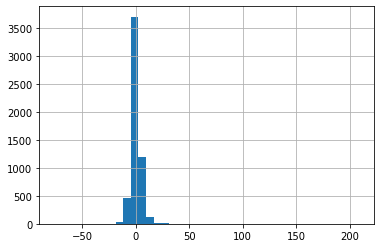

In [18]:
df['fluxo_pct_pop'].hist(bins=40)

# Dados geográficos

In [19]:
gdf_nomes = geopandas.GeoDataFrame(
    df_nomes, geometry=geopandas.points_from_xy(df_nomes.lon, df_nomes.lat))

gdf_nomes = gdf_nomes.set_index('codmun')

gdf_nomes.head()

Município       lat      lon                     geometry
codmun                                                                     
520005      Abadia de Goiás -16.75730 -49.4412  POINT (-49.44120 -16.75730)
310010  Abadia dos Dourados -18.48310 -47.3916  POINT (-47.39160 -18.48310)
520010            Abadiânia -16.19700 -48.7057  POINT (-48.70570 -16.19700)
310020               Abaeté -19.15510 -45.4444  POINT (-45.44440 -19.15510)
150010           Abaetetuba  -1.72183 -48.8788   POINT (-48.87880 -1.72183)

In [20]:
from math import radians, sin, cos, asin, sqrt
def haversine(point1, point2):
    """
    Calculate the great circle distance between two points 
    on the earth (specified in decimal degrees)
    """
    lon1, lat1 = point1.bounds[0], point1.bounds[1]
    lon2, lat2 = point2.bounds[0], point2.bounds[1]

    # convert decimal degrees to radians 
    lon1, lat1, lon2, lat2 = map(radians, [lon1, lat1, lon2, lat2])

    # haversine formula 
    dlon = lon2 - lon1 
    dlat = lat2 - lat1
    a = sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlon/2)**2
    c = 2 * asin(sqrt(a))
    r = 6371 # Radius of earth in kilometers
    # print('Distance from beginning to end of route in km: ',round((c * r), 2),'\n')
    return c * r

def calcula_distancia(mun_orig, mun_dest):
    if (mun_orig in gdf_nomes.index) and (mun_dest in gdf_nomes.index):
        return haversine(gdf_nomes.loc[mun_orig, 'geometry'], gdf_nomes.loc[mun_dest, 'geometry'])
    else:
        return 0.0

In [21]:
d = calcula_distancia(410690, 350950)

d

357.63299997294877

In [22]:
df_exp_mun_todos['distancia'] = df_exp_mun_todos.apply(lambda x: calcula_distancia(x['codmun'], x['codmundest']), axis=1)

df_exp_mun_todos.head()

codmun  codmundest  exportados   distancia
0  110001      110002           1  251.800607
1  110001      110004         180   80.395469
2  110001      110006           1  205.552665
3  110001      110007           2  165.279790
4  110001      110008           6  249.170122

In [23]:
df_exp_mun_todos

codmun  codmundest  exportados   distancia
0       110001      110002           1  251.800607
1       110001      110004         180   80.395469
2       110001      110006           1  205.552665
3       110001      110007           2  165.279790
4       110001      110008           6  249.170122
...        ...         ...         ...         ...
914056  999999      522045           4    0.000000
914057  999999      522060           6    0.000000
914058  999999      522140           2    0.000000
914059  999999      522185           4    0.000000
914060  999999      530010         676    0.000000

[914061 rows x 4 columns]

In [24]:
def distancia_media(grupo): 
    dist = grupo['exportados'] * grupo['distancia']
    dist_media = dist.sum()/grupo['exportados'].sum()
    return dist_media

df_exp_mun_dist = df_exp_mun_todos.groupby(['codmun']).apply(distancia_media).to_frame().reset_index()

df_exp_mun_dist.columns = ['codmun', 'Distância Média']

df_exp_mun_dist

codmun  Distância Média
0     110001       594.018385
1     110002       733.419996
2     110003       522.859053
3     110004       678.221677
4     110005       518.947389
...      ...              ...
5616  539914         0.000000
5617  539921         0.000000
5618  539924         0.000000
5619  666666         0.000000
5620  999999         0.000000

[5621 rows x 2 columns]

In [25]:
# geometrias dos municípios

mun_geo = read_municipality(code_muni="all", year=2018)

mun_geo.crs = "EPSG:4326"

mun_geo = mun_geo[['code_muni', 'geometry']]

mun_geo.columns = ['codmun', 'geometry']

mun_geo['codmun'] = mun_geo['codmun'].astype('int').astype('str').str[:6].astype('int')

mun_geo

codmun                                           geometry
0     110001  MULTIPOLYGON (((-62.23224 -11.90804, -62.20670...
1     110002  MULTIPOLYGON (((-63.57327 -9.78326, -63.57016 ...
2     110003  MULTIPOLYGON (((-60.71834 -13.39058, -60.70904...
3     110004  MULTIPOLYGON (((-61.27873 -11.50596, -61.28097...
4     110005  MULTIPOLYGON (((-61.41347 -13.23417, -61.42603...
...      ...                                                ...
5567  522200  POLYGON ((-48.53842 -16.75003, -48.54051 -16.7...
5568  522205  POLYGON ((-50.00189 -17.78179, -50.01420 -17.7...
5569  522220  POLYGON ((-47.07742 -15.06330, -47.07851 -15.0...
5570  522230  POLYGON ((-48.91463 -15.20939, -48.91532 -15.1...
5571  530010  MULTIPOLYGON (((-47.81455 -16.04995, -48.27781...

[5572 rows x 2 columns]

In [26]:
mun_desc = mun_geo.merge(df, how='left').merge(df_exp_mun_dist, how='left')

mun_desc

codmun                                           geometry  importados  \
0     110001  MULTIPOLYGON (((-62.23224 -11.90804, -62.20670...       969.0   
1     110002  MULTIPOLYGON (((-63.57327 -9.78326, -63.57016 ...      2573.0   
2     110003  MULTIPOLYGON (((-60.71834 -13.39058, -60.70904...       359.0   
3     110004  MULTIPOLYGON (((-61.27873 -11.50596, -61.28097...      7200.0   
4     110005  MULTIPOLYGON (((-61.41347 -13.23417, -61.42603...       866.0   
...      ...                                                ...         ...   
5567  522200  POLYGON ((-48.53842 -16.75003, -48.54051 -16.7...       592.0   
5568  522205  POLYGON ((-50.00189 -17.78179, -50.01420 -17.7...       419.0   
5569  522220  POLYGON ((-47.07742 -15.06330, -47.07851 -15.0...       782.0   
5570  522230  POLYGON ((-48.91463 -15.20939, -48.91532 -15.1...       521.0   
5571  530010  MULTIPOLYGON (((-47.81455 -16.04995, -48.27781...    161477.0   

      exportados  populacao              Município       lat      lon  \
0         1531.0    22728.0  Alta Floresta D'Oeste -11.92830 -61.9953   
1         7326.0   109523.0              Ariquemes  -9.90571 -63.0325   
2          351.0     5188.0                 Cabixi -13.49450 -60.5520   
3         5647.0    85893.0                 Cacoal -11.43430 -61.4562   
4         1228.0    16204.0             Cerejeiras -13.18700 -60.8168   
...          ...        ...                    ...       ...      ...   
5567      1487.0    13977.0             Vianópolis -16.74050 -48.5159   
5568       817.0     8873.0         Vicentinópolis -17.73220 -49.8047   
5569       317.0     6312.0               Vila Boa -15.03870 -47.0520   
5570       652.0     5882.0          Vila Propício -15.45420 -48.8819   
5571    167631.0  3055149.0               Brasília -15.77950 -47.9297   

                                        Maiores origens  \
0     (11%) Rolim de Moura<br>(11%) Alto Alegre dos ...   
1     (13%) Porto Velho<br>(7%) Monte Negro<br>(6%) ...   
2     (38%) Vilhena<br>(25%) Colorado do Oeste<br>(5...   
3     (8%) Espigão D'Oeste<br>(7%) Pimenta Bueno<br>...   
4     (25%) Vilhena<br>(12%) Colorado do Oeste<br>(1...   
...                                                 ...   
5567  (17%) Silvânia<br>(14%) Goiânia<br>(10%) Anápo...   
5568  (21%) Goiatuba<br>(12%) Joviânia<br>(10%) Pont...   
5569  (36%) Formosa<br>(24%) Brasília<br>(4%) Flores...   
5570  (29%) Goianésia<br>(10%) Brasília<br>(8%) Anáp...   
5571  (8%) Valparaíso de Goiás<br>(5%) Águas Lindas ...   

                                       Maiores destinos  aplicadas  \
0     (12%) Rolim de Moura<br>(11%) Cacoal<br>(9%) A...     9636.0   
1     (13%) Porto Velho<br>(7%) Monte Negro<br>(7%) ...    33374.0   
2     (32%) Vilhena<br>(7%) Colorado do Oeste<br>(5%...     2781.0   
3     (8%) Porto Velho<br>(7%) Espigão D'Oeste<br>(6...    44966.0   
4     (19%) Vilhena<br>(12%) Corumbiara<br>(12%) Pim...     6643.0   
...                                                 ...        ...   
5567  (39%) Silvânia<br>(18%) Goiânia<br>(5%) Anápol...     6098.0   
5568  (12%) Goiânia<br>(6%) Joviânia<br>(6%) Pontali...     3406.0   
5569  (30%) Formosa<br>(20%) Brasília<br>(4%) Flores...     2143.0   
5570  (38%) Goianésia<br>(9%) Brasília<br>(9%) Padre...     2379.0   
5571  (8%) Águas Lindas de Goiás<br>(5%) Valparaíso ...  1192285.0   

     ultima_data  fluxo_pct_pop  fluxo_pct_apl  \
0     2021-06-25      -2.472721      -5.832296   
1     2021-06-25      -4.339728     -14.241625   
2     2021-06-25       0.154202       0.287666   
3     2021-06-27       1.808064       3.453721   
4     2021-06-27      -2.234016      -5.449345   
...          ...            ...            ...   
5567  2021-06-26      -6.403377     -14.676943   
5568  2021-06-23      -4.485518     -11.685261   
5569  2021-06-25       7.366920      21.698553   
5570  2021-06-24      -2.227134      -5.506515   
5571  2021-06-27      -0.201430      -0.516152   

                             

In [27]:
mun_desc = mun_desc.fillna(0)

mun_desc

codmun                                           geometry  importados  \
0     110001  MULTIPOLYGON (((-62.23224 -11.90804, -62.20670...       969.0   
1     110002  MULTIPOLYGON (((-63.57327 -9.78326, -63.57016 ...      2573.0   
2     110003  MULTIPOLYGON (((-60.71834 -13.39058, -60.70904...       359.0   
3     110004  MULTIPOLYGON (((-61.27873 -11.50596, -61.28097...      7200.0   
4     110005  MULTIPOLYGON (((-61.41347 -13.23417, -61.42603...       866.0   
...      ...                                                ...         ...   
5567  522200  POLYGON ((-48.53842 -16.75003, -48.54051 -16.7...       592.0   
5568  522205  POLYGON ((-50.00189 -17.78179, -50.01420 -17.7...       419.0   
5569  522220  POLYGON ((-47.07742 -15.06330, -47.07851 -15.0...       782.0   
5570  522230  POLYGON ((-48.91463 -15.20939, -48.91532 -15.1...       521.0   
5571  530010  MULTIPOLYGON (((-47.81455 -16.04995, -48.27781...    161477.0   

      exportados  populacao              Município       lat      lon  \
0         1531.0    22728.0  Alta Floresta D'Oeste -11.92830 -61.9953   
1         7326.0   109523.0              Ariquemes  -9.90571 -63.0325   
2          351.0     5188.0                 Cabixi -13.49450 -60.5520   
3         5647.0    85893.0                 Cacoal -11.43430 -61.4562   
4         1228.0    16204.0             Cerejeiras -13.18700 -60.8168   
...          ...        ...                    ...       ...      ...   
5567      1487.0    13977.0             Vianópolis -16.74050 -48.5159   
5568       817.0     8873.0         Vicentinópolis -17.73220 -49.8047   
5569       317.0     6312.0               Vila Boa -15.03870 -47.0520   
5570       652.0     5882.0          Vila Propício -15.45420 -48.8819   
5571    167631.0  3055149.0               Brasília -15.77950 -47.9297   

                                        Maiores origens  \
0     (11%) Rolim de Moura<br>(11%) Alto Alegre dos ...   
1     (13%) Porto Velho<br>(7%) Monte Negro<br>(6%) ...   
2     (38%) Vilhena<br>(25%) Colorado do Oeste<br>(5...   
3     (8%) Espigão D'Oeste<br>(7%) Pimenta Bueno<br>...   
4     (25%) Vilhena<br>(12%) Colorado do Oeste<br>(1...   
...                                                 ...   
5567  (17%) Silvânia<br>(14%) Goiânia<br>(10%) Anápo...   
5568  (21%) Goiatuba<br>(12%) Joviânia<br>(10%) Pont...   
5569  (36%) Formosa<br>(24%) Brasília<br>(4%) Flores...   
5570  (29%) Goianésia<br>(10%) Brasília<br>(8%) Anáp...   
5571  (8%) Valparaíso de Goiás<br>(5%) Águas Lindas ...   

                                       Maiores destinos  aplicadas  \
0     (12%) Rolim de Moura<br>(11%) Cacoal<br>(9%) A...     9636.0   
1     (13%) Porto Velho<br>(7%) Monte Negro<br>(7%) ...    33374.0   
2     (32%) Vilhena<br>(7%) Colorado do Oeste<br>(5%...     2781.0   
3     (8%) Porto Velho<br>(7%) Espigão D'Oeste<br>(6...    44966.0   
4     (19%) Vilhena<br>(12%) Corumbiara<br>(12%) Pim...     6643.0   
...                                                 ...        ...   
5567  (39%) Silvânia<br>(18%) Goiânia<br>(5%) Anápol...     6098.0   
5568  (12%) Goiânia<br>(6%) Joviânia<br>(6%) Pontali...     3406.0   
5569  (30%) Formosa<br>(20%) Brasília<br>(4%) Flores...     2143.0   
5570  (38%) Goianésia<br>(9%) Brasília<br>(9%) Padre...     2379.0   
5571  (8%) Águas Lindas de Goiás<br>(5%) Valparaíso ...  1192285.0   

     ultima_data  fluxo_pct_pop  fluxo_pct_apl  \
0     2021-06-25      -2.472721      -5.832296   
1     2021-06-25      -4.339728     -14.241625   
2     2021-06-25       0.154202       0.287666   
3     2021-06-27       1.808064       3.453721   
4     2021-06-27      -2.234016      -5.449345   
...          ...            ...            ...   
5567  2021-06-26      -6.403377     -14.676943   
5568  2021-06-23      -4.485518     -11.685261   
5569  2021-06-25       7.366920      21.698553   
5570  2021-06-24      -2.227134      -5.506515   
5571  2021-06-27      -0.201430      -0.516152   

                             

In [28]:
mun_desc['ultima_data'] = mun_desc['ultima_data'].astype('str')

mun_desc.to_file("dados_mapas.geojson", driver='GeoJSON')


In [30]:
mun_desc.drop(['geometry'], axis=1).to_excel("dados_mapas.xls", index=False)

/home/luizcelso/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  """Entry point for launching an IPython kernel.
